**ISSA Salim** <br>
26 Novembre 2024 <br>
## Reconnaissance faciale basée sur la méthode PCA <br>

La reconnaissance faciale est aujourd'hui au cœur des enjeux sociétaux, qu'ils soient éthiques, ou pas. Afin de répondre aux besoins sans cesse croissants d'algorithmes de plus en plus efficaces pour effectuer cette tâche, plusieurs méthodes ont vu le jour dont la PCA (**Principal Component Analysis**) ou l'analyse en composantes principales. <br>
L'idée est d'extraire d'une base de données normalisée de visages, les caractéristiques dominantes à des fins de classification ou de reconnaissance. Nous détaillerons ci-dessous, étape par étape, cette technique dans un cas pratique de reconnaissance faciale.

### Récupération du jeu de données (Olivetti Research Laboratory face database)

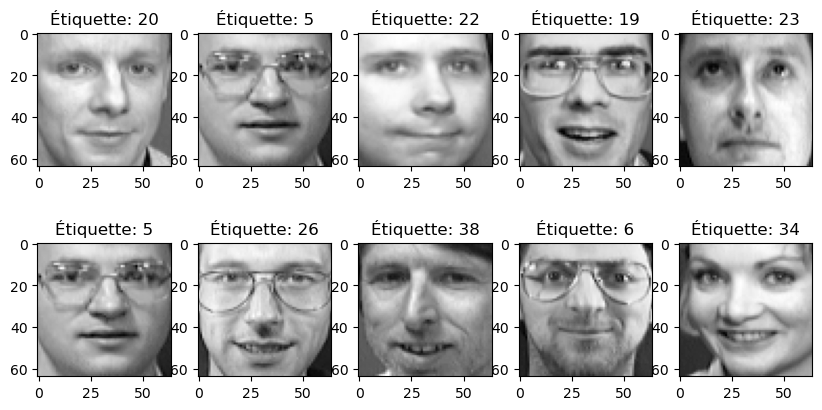

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt,random

# Chargement des données
donnees = fetch_olivetti_faces(shuffle=False,random_state=42)

# Récupération des images et de leurs étiquettes
images = donnees.images
etiquettes = donnees.target # elles nous indiquent de quel individu est l'image

# Affichages de 10 images choisies au hasard
n_lignes,n_colonnes = 2,5  # nombres de lignes et de colonnes
figure,axes = plt.subplots(n_lignes,n_colonnes,figsize=(10,5))
for i in range(n_lignes):
    for j in range(n_colonnes):
        k = random.randint(0,images.shape[0]-1)
        axes[i,j].imshow(images[k],cmap='gray')
        axes[i,j].set_title(f"Étiquette: {etiquettes[k]}")
        k += 1
    
plt.show()

### Construction de la matrice des images vectorisées 

In [2]:
import numpy as np

n_lignes = images[0].shape[0]*images[0].shape[1]
n_colonnes = images.shape[0] #nombre d'images

X = np.zeros((n_lignes,n_colonnes))
for j in range(n_colonnes): 
    X[:,j] = images[j].flatten()

### Détermination de l'image moyenne

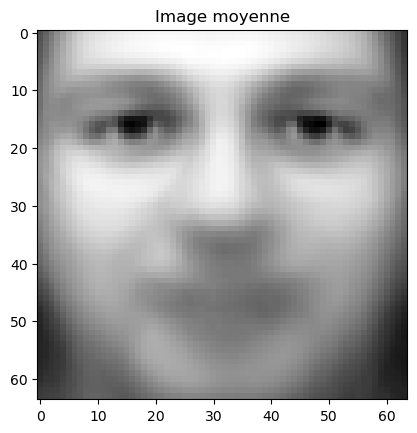

In [3]:
n_images = n_colonnes
PSI = np.sum(X,axis=1)/n_images
image_moyenne = PSI.reshape(images[0].shape)

# Affichage
plt.imshow(image_moyenne,cmap='gray')
plt.title('Image moyenne')
plt.show()

### Détermination de la matrice de covariance C = AA<sup>T</sup> et de ses vecteurs propres

In [4]:
import scipy.linalg as la

def gka(A,k):
    """Algorithme de Golub-Kahan pour calculer les k premières eigenfaces.
    Pour un k très grand, l'accumulation des erreurs d'arrondis érode l'orthogonalité des eigenfaces.
    Une étape de réorthogonalisation des vecteurs par décomposition QR (plus stable numériquement) a 
    donc été ajoutée dès que l'orthogonalité des vecteurs se relâche."""
    
    taille_u = A.shape[0]
    taille_v = A.shape[1]
    Uk = np.zeros((taille_u,k))
    u0 = np.random.rand(taille_u,)
    vk = np.random.rand(taille_v,)
    # normalisation
    u0 /= la.norm(u0)
    vk /= la.norm(vk)
    beta0 = 0
    
    tolerance_orthogonalite = 1e-10
    
    for j in range(k):
        uk = A @ vk - beta0*u0
        alphak = la.norm(uk)
        uk = uk/alphak
        Uk[:,j] = uk
        
        perte_orthogonalite = la.norm(np.dot(Uk.T,Uk)-np.eye(k)) # calcul de la norme de Frobenius
        if perte_orthogonalite > tolerance_orthogonalite: # perte d'orthogonalité détectée
            Uk,_ = np.linalg.qr(Uk) # R est ignorée car pas utile dans ce cas

        vk_new = A.T @ uk - alphak*vk
        beta_new = la.norm(vk_new)
        vk_new = vk_new/beta_new
        vk = vk_new
        beta0 = beta_new
        u0 = uk
    return Uk

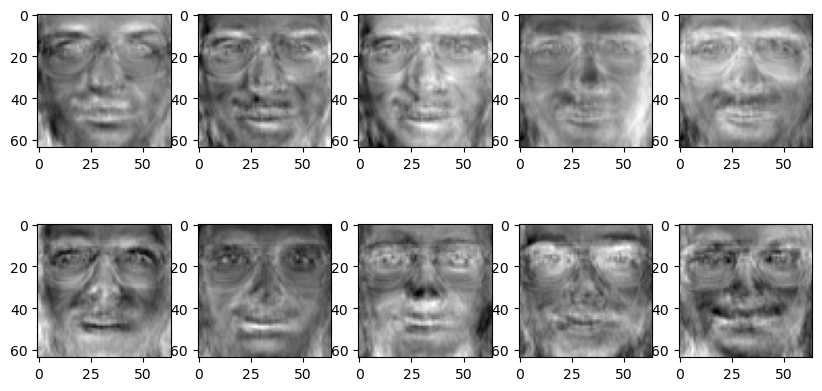

In [5]:
from scipy.sparse.linalg import svds

A = np.zeros_like(X)
for j in range(n_images):
    A[:,j] = X[:,j] - PSI

k = 100 # nombre d'eigenfaces à considérer

# Calculs des k premières eigenfaces (valeurs propres de AA^T)
choix_methode = 2 # 0: svd complète, 1: tsvd avec scipy, sinon: gka

if choix_methode == 0: # méthode directe (plus lente)
    U,SIGMA,Vt = la.svd(A)
    Uk = U[:,0:k]
elif choix_methode == 1: # méthode itérative basée sur l'algorithme de Golub-Kahan
    Uk,SIGMA_k,Vt_k = svds(A,k=k)
else: # algorithme de Golub-Kahan (gka) from scratch
    Uk = gka(A,k=k)
    
    
# Affichage des 10 premières eigenfaces
n_lignes,n_colonnes = 2,5  # nombres de lignes et de colonnes
figure,axes = plt.subplots(n_lignes,n_colonnes,figsize=(10,5))
l = 0
forme_image = images[0].shape
for i in range(n_lignes):
    for j in range(n_colonnes):
        if l < k:
            axes[i,j].imshow(Uk[:,l].reshape(forme_image),cmap='gray')
            l += 1 

### Tests de reconnaissance d'un visage tiré au hasard

Un visage a été détecté.


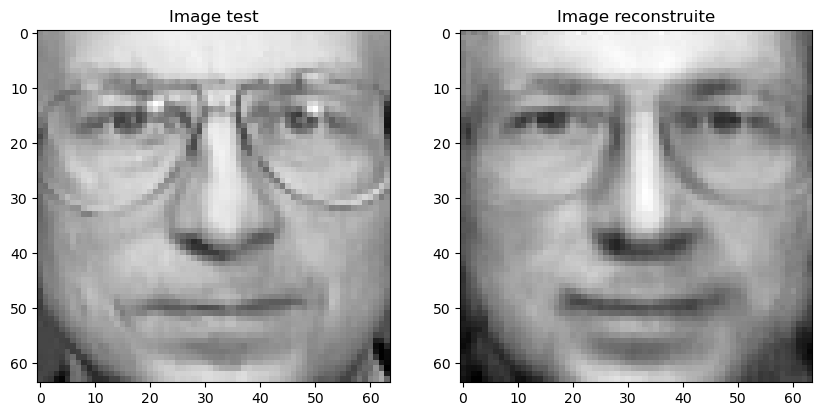

In [6]:
i = random.randint(0,n_images-1)
Z_image = images[i]
I = etiquettes[i] # récupération de la classe de l'image (individu auquel elle appartient)
I_indices = np.where(etiquettes == I)[0]

n_images = len(I_indices) # nombre d'images obtenues

Z = Z_image.flatten() #Vectorisation de l'image test

# Construction de la matrice des images de la classe vectorisées
Zi = np.zeros((X.shape[0],n_images))
j = 0
for indice in I_indices:
    Zi[:,j] = images[indice].flatten()
    j += 1
    
# Projection de l'image test sur l'espace des eigenfaces
OMEGA = Uk.T.dot(Z-PSI)

# Matrice contenant les projections des images de la classe sur l'espace des eigenfaces
OMEGA_i = np.zeros((len(OMEGA),n_images))
for i in range(n_images):
    omega_i = Uk.T.dot(Zi[:,i]-PSI)
    OMEGA_i[:,i] = omega_i

# Image reconstruite à partir des eigenfaces
Zr = Uk.dot(OMEGA)+PSI
Zr_image = Zr.reshape(forme_image)

# Calcul de la distance euclidienne entre l'image test et sa reconstruction
epsilon = la.norm(Z-Zr)

# Distance euclidienne des projections entre l'image test et les images de la classe
epsilon_i = np.array([])
for i in range(n_images):
    epsilon_i = np.append(epsilon_i,la.norm(OMEGA-OMEGA_i[:,i]))
    #epsilon_i = np.append(epsilon_i,la.norm(Z-Zi[:,i]))
    
# Détermination du seuil thêta
theta_ij = np.array([])
for i in range(n_images):
    for j in range(n_images):
        theta_ij = np.append(theta_ij,la.norm(OMEGA_i[:,i]-OMEGA_i[:,j]))
        
theta = np.max(theta_ij)/2

# Évaluation des résultats de la reconnaissance
if epsilon >= theta:
    print("Il ne s'agit pas d'un visage. Image non reconnue.")
else:
    print("Un visage a été détecté.")
    if np.all(epsilon_i >= theta):
        print("Mais est il est inconnu.")
    if np.all(epsilon_i < theta):
        print("C'est l'individu de la classe {0:2d}.".format(I))
        
# Affichage de l'image choisie et de sa reconstruction
n_lignes,n_colonnes = 1,2  # nombres de lignes et de colonnes
figure,axes = plt.subplots(n_lignes,n_colonnes,figsize=(10,5))
axes[0].imshow(Z_image,cmap='gray')
axes[0].set_title('Image test')
axes[1].imshow(Zr_image,cmap='gray')
axes[1].set_title('Image reconstruite')
plt.show()